In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Exponential Mixture Model

En esta notebook se realizará un modelo similar al Guassian Mixture Model (de aquí en más GMM) pero utilizando en vez de una distribución gaussiana, una exponencial. 


In [41]:
import numpy as np
import pandas as pd

class ExponentialMixtureModel():
    def __init__(self, k: int, max_iter: int = 100, tol: float = 1e-6) -> None:
        self.k = k  # Número de clusters
        self.max_iter = max_iter  # Máximo número de iteraciones
        self.tol = tol  # Tolerancia para la convergencia
        self.weights = None  # Pesos de cada cluster
        self.lambdas = None  # Parámetros lambda de cada cluster

    def _prepare_data(self, X: np.ndarray | pd.DataFrame):
        '''
        Convierte los datos en X en una matriz 2D si es necesario, para que tenga siempre la forma (n_samples, n_features).
        
        Parámetros:
        X: np.ndarray o pd.DataFrame con forma (n_samples,) o (n_samples, n_features)
        '''
        if isinstance(X, pd.DataFrame):
            return X.values
        elif X.ndim == 1:
            return X.reshape(-1, 1)
        return X

    def initialize_parameters(self, X: np.ndarray | pd.DataFrame) -> None:
        # Prepara los datos
        X = self._prepare_data(X)

        # Obtener cantidad de observaciones y features
        n_samples, n_features = X.shape

        # Inicializar pesos uniformemente
        self.weights = np.full(self.k, 1 / self.k)

        # Inicializar lambdas aleatoriamente
        self.lambdas = np.random.uniform(1, 10, (self.k, n_features))
        
        print("Pesos iniciales:\n", self.weights)
        print("Parámetros iniciales (lambdas):\n", self.lambdas)

    def e_step(self, X):
        # En este paso se calcula la probabilidad de pertenecer al cluster j dado las X ponderadas 
        # por el peso de cada cluster, inicializado anteriormente. Es una regla de bayes ponderada con la exponencial como fx
        
        # Preparar los datos
        X = self._prepare_data(X)
        n_samples, n_features = X.shape

        self.e_return = np.zeros((n_samples, self.k))
        for k in range(self.k):
            # Calcular la probabilidad de pertenencia a cada cluster
            probs = self.weights[k] * np.prod(self.lambdas[k] * np.exp(-self.lambdas[k] * X), axis=1)
            probs = np.where(probs < 1e-10, 1e-10, probs)  # Evitar cero
            self.e_return[:, k] = probs

        # Normalizar las probabilidades para que sumen 1 por observación
        self.e_return = self.e_return / self.e_return.sum(axis=1, keepdims=True)
        if np.any(np.isnan(self.e_return)):
            raise ValueError("Se encontraron NaNs en la matriz de probabilidad después del paso E.")
            # print("Advertencia: NaNs encontrados en la matriz de probabilidad después del paso E.")

    def m_step(self, X):
        X = self._prepare_data(X)
        n_samples, n_features = X.shape
        
        # Se obtiene la suma de wij que es la probabilidad condicional normalizada obtenida en el e_step 
        # y se la divide por n. Se debe iterar por la cantidad K y cantidad de features
        for k in range(self.k):
            # Sumamos los las probabilidades condicionales normalizadas por cluster
            resp_sum = np.sum(self.e_return[:, k])

            # Actualizamos los pesos utilizando la CPO para estos parámetros
            self.weights[k] = resp_sum / n_samples
            
            # Actualizamos los parámetros lambda utilizando la CPO para estos parámetros
            for j in range(n_features):
                # La suma ponderada de cada valor de observación en cada feature por la probabilidad de pertenecer a esa clase
                weighted_sum = np.sum(self.e_return[:, k] * X[:, j])
                if weighted_sum == 0:
                    self.lambdas[k, j] = 1e-6  # Corrección para evitar división por cero
                else:
                    self.lambdas[k, j] = resp_sum / weighted_sum

        if np.any(np.isnan(self.weights)) or np.any(np.isnan(self.lambdas)):
            raise ValueError("Se encontraron NaNs en los pesos o parámetros después del paso M.")
            # print("Advertencia: NaNs encontrados en los pesos o parámetros después del paso M.")

    def fit(self, X):
        X = self._prepare_data(X)
        self.initialize_parameters(X)

        log_likelihood_old = -np.inf

        for i in range(self.max_iter):
            self.e_step(X)  # Paso E
            self.m_step(X)  # Paso M
            
            # Calcular log-verosimilitud
            log_likelihood = np.sum(np.log(np.sum(self.e_return, axis=1) + 1e-10))  # Corrección para evitar log(0)
            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                print(f"Convergencia alcanzada en la iteración {i}.")
                break

            log_likelihood_old = log_likelihood
            print(f"Iteración {i}, log-likelihood: {log_likelihood}")

    def predict_proba(self, X):
        X = self._prepare_data(X)
        self.e_step(X)
        return self.e_return

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Ejemplo de uso

In [57]:
np.random.seed(0)
# X = np.concatenate([
#     np.random.exponential(scale=1/2, size=100),  
#     np.random.exponential(scale=1/5, size=100) 
# ])

X = pd.DataFrame({
    'X1': np.random.exponential(scale=1/2, size=100),  
    'X2': np.random.exponential(scale=1/5, size=100)})

# Crear y ajustar el modelo
emm = ExponentialMixtureModel(k=2, max_iter=1000)
emm.fit(X)

# Predicciones
print("Pesos de mezcla:\n", emm.weights)
print("Tasas (lambda):\n", emm.lambdas)

clusters = emm.predict(X)
print("\nAsignación de clusters:", clusters)
print("Matriz de probabilidad:",emm.predict_proba(X))

Pesos iniciales:
 [0.5 0.5]
Parámetros iniciales (lambdas):
 [[3.80616294 7.2670914 ]
 [4.39976655 2.6164331 ]]
Iteración 0, log-likelihood: 9.999997274190034e-09
Convergencia alcanzada en la iteración 1.
Pesos de mezcla:
 [0.54749549 0.45250451]
Tasas (lambda):
 [[1.83040555 6.34048387]
 [2.82439975 3.65110362]]

Asignación de clusters: [0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0]
Matriz de probabilidad: [[0.52374571 0.47625429]
 [0.68214273 0.31785727]
 [0.51321092 0.48678908]
 [0.25699224 0.74300776]
 [0.60557501 0.39442499]
 [0.58976087 0.41023913]
 [0.52809547 0.47190453]
 [0.72252746 0.27747254]
 [0.8606207  0.1393793 ]
 [0.25111459 0.74888541]
 [0.6834565  0.3165435 ]
 [0.41948483 0.58051517]
 [0.51980567 0.48019433]
 [0.80379236 0.19620764]
 [0.36382919 0.63617081]
 [0.52058662 0.47941338]
 [0.30437897 0.69562103]
 [0.674

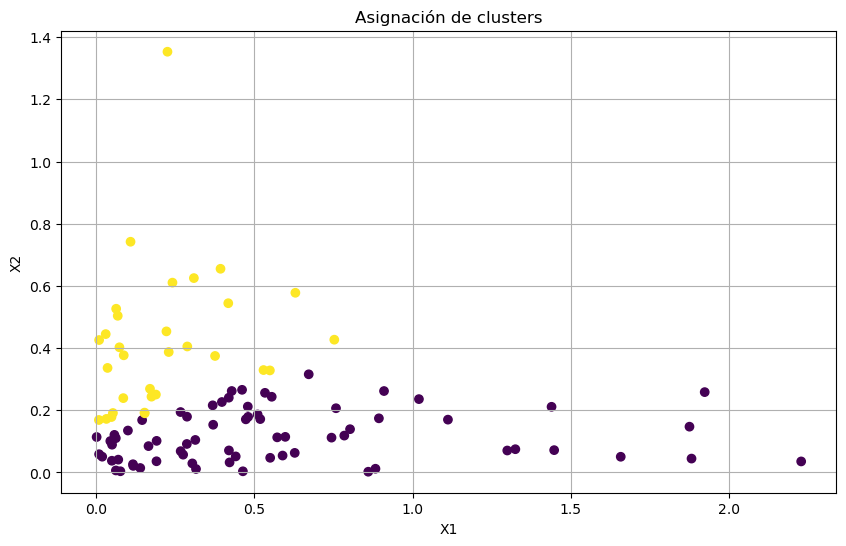

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X['X1'], X['X2'], c=clusters, cmap='viridis')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Asignación de clusters')
ax.grid(True)